<a href="https://colab.research.google.com/github/wxmiked/cannabis-deforestation/blob/feature-add-download-naip/notebooks/custom_raster_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NAIP Custom Raster Datasets

Mike Dvorak [mike@weathertactics.io](mailto:mike@weathertactics.io)

A custom `GeoDataset` class for the [Microsoft Planetary Computer NAIP archive](https://planetarycomputer.microsoft.com/dataset/naip). This notebook is derived from the Custom Raster Datasets tutorial on the TorchGeo site originally written by Ritwik Gupta.

## Setup

First, we install TorchGeo and a couple of other dependencies for downloading data from Microsoft's Planetary Computer.

In [1]:
%pip install torchgeo planetary_computer pystac

  Using cached planetary_computer-1.0.0-py3-none-any.whl.metadata (7.4 kB)
  Using cached pystac-1.12.2-py3-none-any.whl.metadata (4.6 kB)
Note: you may need to restart the kernel to use updated packages.


## Imports

Next, we import TorchGeo and any other libraries we need.

In [2]:
import os
import tempfile
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import planetary_computer
import pystac
import torch
from torch.utils.data import DataLoader

from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

## Downloading

Let's download some data to play around with. In this example, we'll create a dataset for loading Sentinel-2 images. Yes, TorchGeo already has a built-in class for this, but we'll use it as an example of the steps you would need to take to add a dataset that isn't yet available in TorchGeo. We'll show how to download a few bands of Sentinel-2 imagery from the Planetary Computer. This may take a few minutes.

In [3]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [14]:
time_range = "2016-01-01/2016-12-31"
bbox = [-120.64352644032967, 38.172243149955314, -120.47900955503205, 38.32443090099175]

search = catalog.search(collections=["naip"], bbox=bbox, datetime=time_range)
items = search.get_all_items()
items

/Users/wxmiked/vscode-workspace/cannabis/cannabis-deforestation/.venv/lib/python3.11/site-packages/pystac_client/item_search.py:896: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


In [15]:
import os
from urllib.parse import urlparse
import tempfile

root = os.path.join(tempfile.gettempdir(), 'naip')
os.makedirs(root, exist_ok=True)  # Ensure the directory exists

for item in items:
    signed_item = planetary_computer.sign(item)
    url = signed_item.assets["image"].href
    filename = urlparse(url).path.split('/')[-1]
    
    # Check if file already exists
    filepath = os.path.join(root, filename)
    if not os.path.exists(filepath):
        print(f"Downloading {filename}...")
        download_url(url, root, filename)
    else:
        print(f"Skipping {filename} - already exists")

Skipping m_3812053_sw_10_h_20160620.tif - already exists
Skipping m_3812053_nw_10_h_20160620.tif - already exists
Skipping m_3812052_sw_10_h_20160620.tif - already exists
Skipping m_3812052_se_10_h_20160620.tif - already exists
Skipping m_3812052_nw_10_h_20160620.tif - already exists
Skipping m_3812052_ne_10_h_20160620.tif - already exists
Skipping m_3812051_se_10_h_20160620.tif - already exists


100%|██████████| 452M/452M [06:45<00:00, 1.11MB/s] 


100%|██████████| 473M/473M [01:12<00:00, 6.48MB/s] 


100%|██████████| 468M/468M [01:38<00:00, 4.76MB/s] 


100%|██████████| 448M/448M [02:28<00:00, 3.03MB/s] 


100%|██████████| 454M/454M [01:14<00:00, 6.06MB/s] 


100%|██████████| 459M/459M [01:48<00:00, 4.25MB/s] 


100%|██████████| 465M/465M [06:35<00:00, 1.17MB/s] 


100%|██████████| 451M/451M [01:14<00:00, 6.03MB/s] 


100%|██████████| 455M/455M [01:12<00:00, 6.24MB/s] 


This downloads the following files:

In [16]:
sorted(os.listdir(root))

['m_3812043_ne_10_h_20160620.tif',
 'm_3812043_se_10_h_20160620.tif',
 'm_3812044_ne_10_h_20160620.tif',
 'm_3812044_nw_10_h_20160620.tif',
 'm_3812044_se_10_h_20160620.tif',
 'm_3812044_sw_10_h_20160620.tif',
 'm_3812045_nw_10_h_20160620.tif',
 'm_3812045_sw_10_h_20160620.tif',
 'm_3812051_ne_10_h_20160620.tif',
 'm_3812051_se_10_h_20160620.tif',
 'm_3812052_ne_10_h_20160620.tif',
 'm_3812052_nw_10_h_20160620.tif',
 'm_3812052_se_10_h_20160620.tif',
 'm_3812052_sw_10_h_20160620.tif',
 'm_3812053_nw_10_h_20160620.tif',
 'm_3812053_sw_10_h_20160620.tif']

As you can see, each spectral band is stored in a different file. We have downloaded 2 total scenes, each with 4 spectral bands.

## Defining a dataset

To define a new dataset class, we subclass from `RasterDataset`. `RasterDataset` has several class attributes used to customize how to find and load files.

### `filename_glob`

In order to search for files that belong in a dataset, we need to know what the filenames look like. In our Sentinel-2 example, all files start with a capital `T` and end with `_10m.tif`. We also want to make sure that the glob only finds a single file for each scene, so we'll include `B02` in the glob. If you've never used Unix globs before, see Python's [fnmatch](https://docs.python.org/3/library/fnmatch.html) module for documentation on allowed characters.

### `filename_regex`

Rasterio can read the geospatial bounding box of each file, but it can't read the timestamp. In order to determine the timestamp of the file, we'll define a `filename_regex` with a group labeled "date". If your files don't have a timestamp in the filename, you can skip this step. If you've never used regular expressions before, see Python's [re](https://docs.python.org/3/library/re.html) module for documentation on allowed characters.

### `date_format`

The timestamp can come in many formats. In our example, we have the following format:

* 4 digit year (`%Y`)
* 2 digit month (`%m`)
* 2 digit day (`%d`)
* the letter T
* 2 digit hour (`%H`)
* 2 digit minute (`%M`)
* 2 digit second (`%S`)

We'll define the `date_format` variable using [datetime format codes](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes).

### `is_image`

If your data only contains model inputs (such as images), use `is_image = True`. If your data only contains ground truth model outputs (such as segmentation masks), use `is_image = False` instead.

Consequently, the sample returned by the dataset/data loader will use the "image" key if *is_image* is True, otherwise it will use the "mask" key.

For datasets with both model inputs and outputs, the recommended approach is to use 2 `RasterDataset` instances and combine them using an `IntersectionDataset`. See L7 Irish, L8 Biome, and I/O Bench for examples of this in `torchgeo/datasets`.

### `dtype`

Defaults to float32 for `is_image == True` and long for `is_image == False`. This is what you want for 99% of datasets, but can be overridden for tasks like pixel-wise regression (where the target mask should be float32).

### `resampling`

Defaults to bilinear for float Tensors and nearest for int Tensors. Can be overridden for custom resampling algorithms.

### `separate_files`

If your data comes with each spectral band in a separate files, as is the case with Sentinel-2, use `separate_files = True`. If all spectral bands are stored in a single file, use `separate_files = False` instead.

### `all_bands`

If your data is a multispectral image, you can define a list of all band names using the `all_bands` variable.

### `rgb_bands`

If your data is a multispectral image, you can define which bands correspond to the red, green, and blue channels. In the case of Sentinel-2, this corresponds to B04, B03, and B02, in that order.

Putting this all together into a single class, we get:

In [26]:
class Naip(RasterDataset):
    filename_glob = 'm_*.tif'
    filename_regex = r'^m_[0-9]{7}_[nsew]{2}_10_h_(?P<date>\d{8})'
    date_format = '%Y%m%d'
    is_image = True
    separate_files = False
    all_bands = ('R', 'G', 'B', 'NIR')
    rgb_bands = ('R', 'G', 'B',)

We can now instantiate this class and see if it works correctly.

In [27]:
dataset = Naip(root)
print(root)
os.listdir(root)

/var/folders/56/gwh1m3s973l4jc97_wdr2qqw0000gn/T/naip


['m_3812045_nw_10_h_20160620.tif',
 'm_3812043_ne_10_h_20160620.tif',
 'm_3812044_se_10_h_20160620.tif',
 'm_3812051_ne_10_h_20160620.tif',
 'm_3812052_nw_10_h_20160620.tif',
 'm_3812052_se_10_h_20160620.tif',
 'm_3812044_nw_10_h_20160620.tif',
 'm_3812053_nw_10_h_20160620.tif',
 'm_3812043_se_10_h_20160620.tif',
 'm_3812045_sw_10_h_20160620.tif',
 'm_3812052_sw_10_h_20160620.tif',
 'm_3812044_ne_10_h_20160620.tif',
 'm_3812051_se_10_h_20160620.tif',
 'm_3812044_sw_10_h_20160620.tif',
 'm_3812052_ne_10_h_20160620.tif',
 'm_3812053_sw_10_h_20160620.tif']

As expected, we have a GeoDataset of size 2 because there are 2 scenes in our root data directory.

## Plotting

A great test to make sure that the dataset works correctly is to try to plot an image. We'll add a plot function to our dataset to help visualize it. First, we need to modify the image so that it only contains the RGB bands, and ensure that they are in the correct order. We also need to ensure that the image is in the range 0.0 to 1.0 (or 0 to 255). Finally, we'll create a plot using matplotlib.

In [34]:
class Naip(RasterDataset):
    filename_glob = 'm_*.tif'
    filename_regex = r'^m_[0-9]{7}_[nsew]{2}_10_h_(?P<date>\d{8})'
    date_format = '%Y%m%d'
    is_image = True
    separate_files = False
    all_bands = ('R', 'G', 'B', 'NIR')
    rgb_bands = ('R', 'G', 'B',)

    def __getitem__(self, index):
        sample = super().__getitem__(index)
        # Normalize image to [0, 1]
        image = sample['image']
        image = (image - image.min()) / (image.max() - image.min())
        sample['image'] = image
        return sample

    def plot(self, sample):
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        # Reorder and rescale the image
        image = sample['image'][rgb_indices].permute(1, 2, 0)
        # image = torch.clamp(image / 10000, min=0, max=1).numpy()

        # Plot the image
        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig

Let's plot an image to see what it looks like. We'll use `RandomGeoSampler` to load small patches from each image.

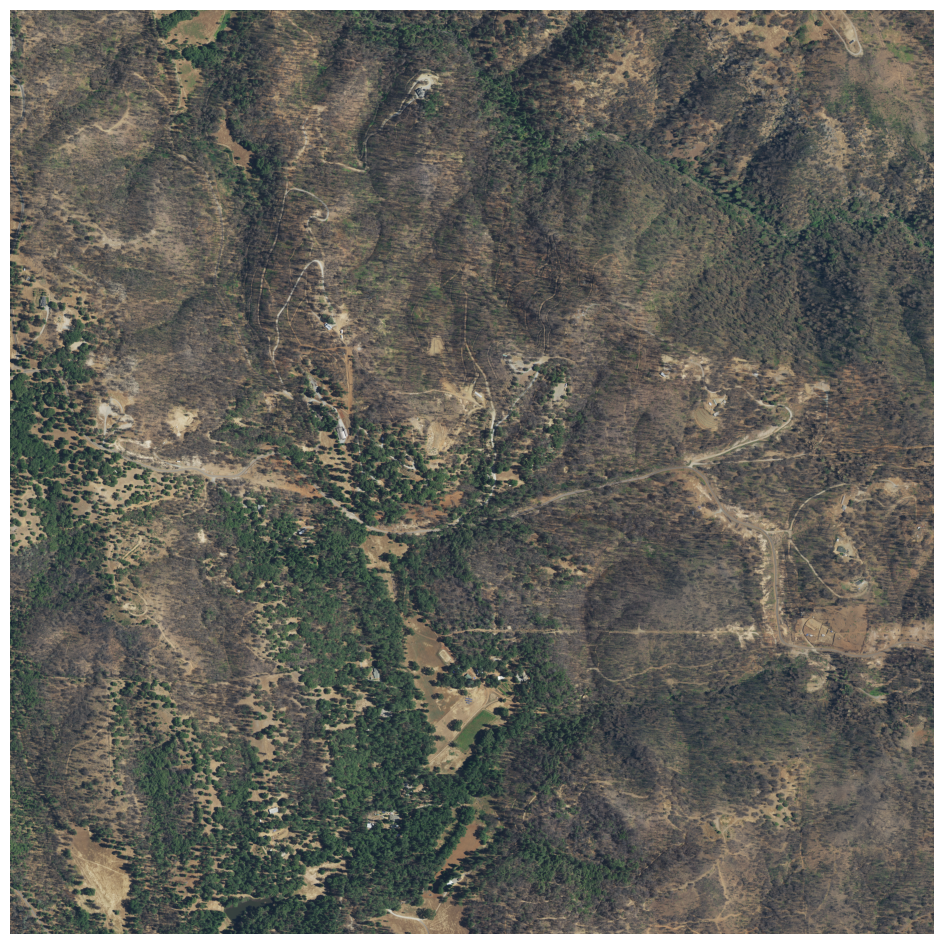

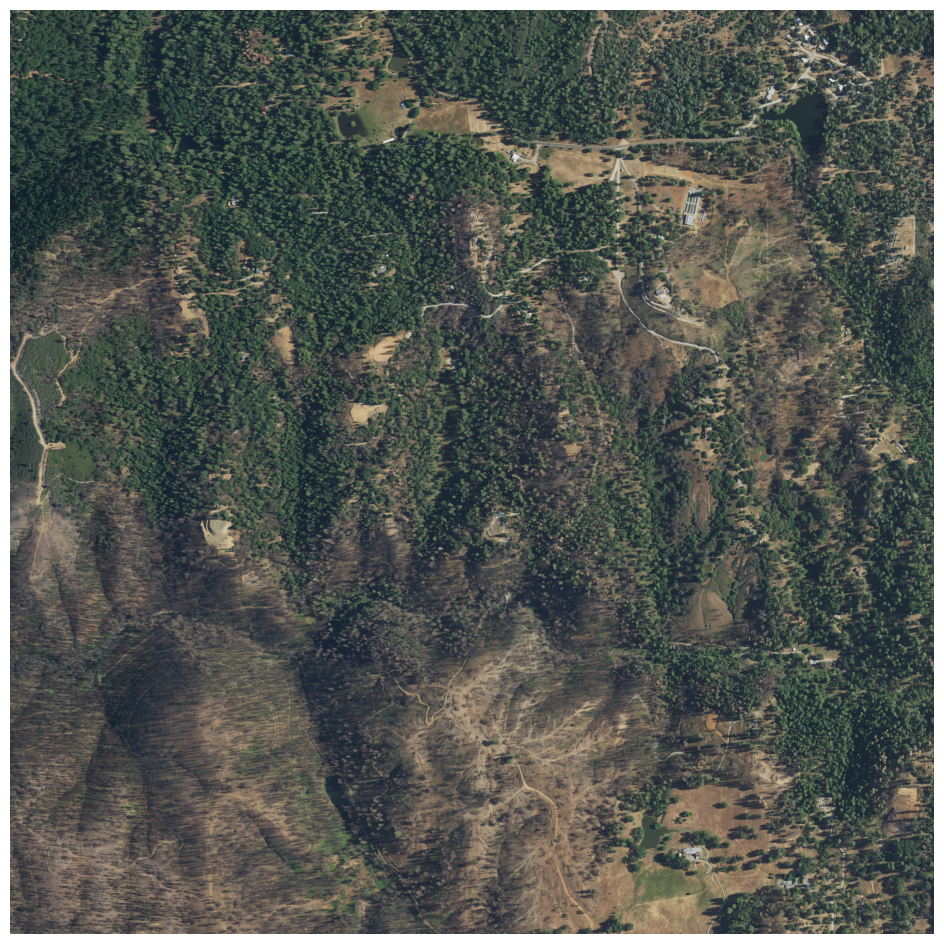

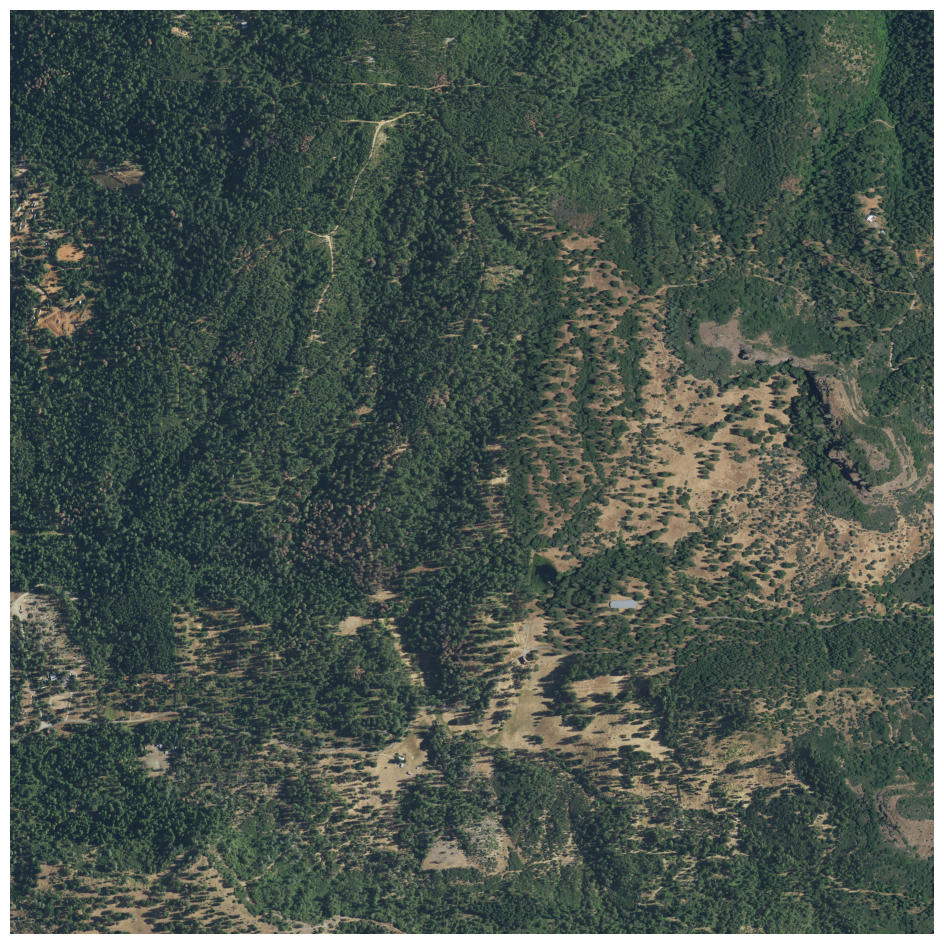

In [35]:
dataset = Naip(root)
g = torch.Generator().manual_seed(1)
sampler = RandomGeoSampler(dataset, size=4096, length=3)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

for batch in dataloader:
    sample = unbind_samples(batch)[0]
    dataset.plot(sample)
    plt.axis('off')
    plt.show()

## Custom parameters

If you want to add custom parameters to the class, you can override the `__init__` method. For example, let's say you have imagery that can be automatically downloaded. The `RasterDataset` base class doesn't support this, but you could add support in your subclass. Simply copy the parameters from the base class and add a new `download` parameter.

In [ ]:
class Downloadable(RasterDataset):
    def __init__(self, paths, crs, res, bands, transforms, cache, download=False):
        if download:
            # download the dataset
            ...

        super().__init__(paths, crs, res, bands, transforms, cache)

## Contributing

TorchGeo is an open source ecosystem built from the contributions of users like you. If your dataset might be useful for other users, please consider contributing it to TorchGeo! You'll need a bit of documentation and some testing before your dataset can be added, but it will be included in the next minor release for all users to enjoy. See the [Contributing](https://torchgeo.readthedocs.io/en/stable/user/contributing.html) guide to get started.